# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

Read the classes names 

In [0]:
f = open("animal8.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/snake.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/flamingo.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/panda.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rabbit.npy


# Imports 

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [0]:
print(len(x_train))

25600


Show some random data 

flamingo


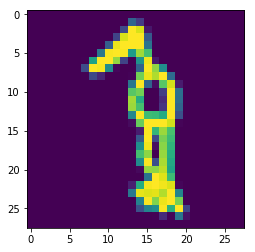

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [0]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax')) 
# Train model
adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flat

# Training 

In [0]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 23040 samples, validate on 2560 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 4s - loss: 1.3067 - top_k_categorical_accuracy: 0.9366 - val_loss: 0.9531 - val_top_k_categorical_accuracy: 0.9766
Epoch 2/5
 - 1s - loss: 0.8419 - top_k_categorical_accuracy: 0.9752 - val_loss: 0.7317 - val_top_k_categorical_accuracy: 0.9832
Epoch 3/5
 - 1s - loss: 0.6858 - top_k_categorical_accuracy: 0.9806 - val_loss: 0.6200 - val_top_k_categorical_accuracy: 0.9840
Epoch 4/5
 - 1s - loss: 0.6102 - top_k_categorical_accuracy: 0.9839 - val_loss: 0.5968 - val_top_k_categorical_accuracy: 0.9832
Epoch 5/5
 - 1s - loss: 0.5626 - top_k_categorical_accuracy: 0.9868 - val_loss: 0.5536 - val_top_k_categorical_accuracy: 0.9859


# Testing 

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 98.62%


# Inference 

['snake', 'camel', 'fish', 'bird', 'rabbit']


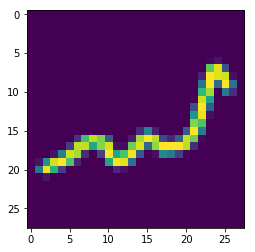

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [0]:
!pip install tensorflowjs 

    100% |████████████████████████████████| 13.9MB 3.5MB/s 
    100% |████████████████████████████████| 86.5MB 391kB/s 
    100% |████████████████████████████████| 81kB 23.3MB/s 
    100% |████████████████████████████████| 3.0MB 9.7MB/s 
    100% |████████████████████████████████| 61kB 23.7MB/s 
    100% |████████████████████████████████| 368kB 20.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.1

# Save and Convert 

In [0]:
model.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

mkdir: cannot create directory ‘model’: File exists
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'


# Zip and Download 

In [0]:
!cp class_names.txt model/class_names.txt

In [0]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 85%)
  adding: model/class_names.txt (deflated 4%)
  adding: model/group1-shard1of1.bin (deflated 8%)


In [0]:
from google.colab import files
files.download('model.zip')